## BOAZ Mini Project

### h1b data [h1b_train, h1b_dev, h1b_test]

- Use h1b __train data__ for train your model.
- Tune your model with __dev data__.
- Finally check your best performed model score with __test data__.
- __*You should clean your train dev test data first!!*__
- Score function : Accuracy
<br>
<br>
- __Your goal is to predict CASE_STATUS, using other features.__
- You can choose the features you want to use in your project.

### Attribute Information

- __CASE_STATUS__
    - The CASE_STATUS field denotes the status of the application after LCA processing. Certified applications are filed with USCIS for H-1B approval.
<br>
<br>
- EMPLOYER_NAME
    - Name of the employer submitting labor condition application.
<br>
<br>
- SOC_NAME
    - Occupational name associated with the SOC_CODE. SOC_CODE is the occupational code associated with the job being requested for temporary labor condition, as classified by the Standard Occupational Classification (SOC) System.
<br>
<br>
- JOB_TITLE
    - Title of the job.
<br>
<br>
- FULL_TIME_POSITION
    - Y = Full Time Position; N = Part Time Position.
<br>
<br>
- PREVAILING_WAGE
    - Prevailing Wage for the job being requested for temporary labor condition. The wage is listed at annual scale in USD. The prevailing wage for a job position is defined as the average wage paid to similarly employed workers in the requested occupation in the area of intended employment. The prevailing wage is based on the employer’s minimum requirements for the position.
<br>
<br>
- YEAR
    - Year in which the H-1B visa petition was filed.
<br>
<br>

### In this assignment, you will design, implement, and evaluate the appropriate models for given data.
0. Preprocess; normalization, feature selection, etc.
1. Model selection; characteristics of datasets need to be comprehended.
2. Evaluation; This step should be done properly to prevent overfitting problem."
3. Enhancement; parameter tuning and feature selection, etc.

## 라이브러리 불러오기

In [2]:
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from subprocess import check_output
from matplotlib.ticker import FuncFormatter
%matplotlib inline

## 전처리 & EDA

### X,y로 나누기

In [3]:
df_train = pd.read_csv('C://Users/test/Desktop/BOAZ/session/BOAZ Mini Project/h1b_train.csv')
df_test = pd.read_csv('C://Users/test/Desktop/BOAZ/session/BOAZ Mini Project/h1b_test_no_ylabel.csv')
df_dev = pd.read_csv('C://Users/test/Desktop/BOAZ/session/BOAZ Mini Project/h1b_dev.csv')

In [4]:
df_train['TEST'] = 0
df_test['TEST'] = 1
df_dev['TEST'] = 0

In [5]:
print('Number of entries:', df_test.shape[0])

Number of entries: 541560


In [6]:
df_all = pd.concat([df_train, df_test])

C:\Users\test\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [7]:
df_all = pd.concat([df_all, df_dev])

C:\Users\test\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [8]:
df_ident = df_all['TEST'] == 1

In [9]:
print('Number of entries:', df_test.shape[0])

Number of entries: 541560


In [10]:
print('Number of entries:', df_all.shape[0])
print(df_all.isnull().sum())

Number of entries: 2944018
CASE_STATUS           541570
EMPLOYER_NAME             50
FULL_TIME_POSITION        12
JOB_TITLE                 38
PREVAILING_WAGE           78
SOC_NAME               17360
TEST                       0
Unnamed: 0                 0
WORKSITE                   0
YEAR                      10
lat                   105188
lon                   105188
dtype: int64


In [11]:
del df_all['lat']
del df_all['lon']
del df_all['Unnamed: 0']
del df_all['JOB_TITLE']

In [12]:
print('Number of entries:', df_all.shape[0])
print(df_all.isnull().sum())

Number of entries: 2944018
CASE_STATUS           541570
EMPLOYER_NAME             50
FULL_TIME_POSITION        12
PREVAILING_WAGE           78
SOC_NAME               17360
TEST                       0
WORKSITE                   0
YEAR                      10
dtype: int64


In [13]:
df_all['SOC_NAME'] = df_all['SOC_NAME'].str.upper()

### 주(state)만 분리하기

In [14]:
def state(data):
    states = []
    data_worksite = df_all['WORKSITE']
    for worksite in data_worksite.iloc[:]:
        state = worksite.split(', ')[1]
        states.append(state)
    return pd.DataFrame(states, columns =['State'])

states = state(df_all)
df_all['State'] = states['State']

In [15]:
df_all['State'].head()

0    CALIFORNIA
1    CALIFORNIA
2    CALIFORNIA
3      ILLINOIS
4      VIRGINIA
Name: State, dtype: object

### case status 확인

### certified랑 denied만 남기기

In [17]:
df1 = df_all[df_all.CASE_STATUS != 'REJECTED']
df1 = df1[df1.CASE_STATUS != 'WITHDRAWN'] 
df1 = df1[df1.CASE_STATUS != 'CERTIFIED-WITHDRAWN']
df1 = df1[df1.CASE_STATUS != 'PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED']

In [19]:
df1.shape[0]

2709979

In [20]:
df1['CASE_STATUS'].value_counts().sort_values(ascending=False)

CERTIFIED    2092970
DENIED         75439
Name: CASE_STATUS, dtype: int64

In [21]:
75439/2709979 #2.78%의 DINIED 비율

0.027837485087522817

In [28]:
df1['FULL_TIME_POSITION'] = df1['FULL_TIME_POSITION'].replace('Y',1)
df1['FULL_TIME_POSITION'] = df1['FULL_TIME_POSITION'].replace('N',0)

In [29]:
df1.head()

,CASE_STATUS,EMPLOYER_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,SOC_NAME,TEST,WORKSITE,YEAR,State
0,CERTIFIED,"INTERNATIONAL SYSTEMS TECHNOLOGIES, INC.",1.0,61589.0,COMPUTER PROGRAMMERS,0,"SUNNYVALE, CALIFORNIA",2014.0,CALIFORNIA
1,CERTIFIED,GOOGLE INC.,1.0,79144.0,NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS,0,"SAN FRANCISCO, CALIFORNIA",2015.0,CALIFORNIA
2,CERTIFIED,WIPRO LIMITED,1.0,73882.0,"COMPUTER OCCUPATIONS, ALL OTHER",0,"EL SEGUNDO, CALIFORNIA",2014.0,CALIFORNIA
3,CERTIFIED,"CPO SERVICES, INC.",1.0,61589.0,ORTHOTISTS AND PROSTHETISTS,0,"PEORIA, ILLINOIS",2011.0,ILLINOIS
5,DENIED,"UNIVERSITY OF CALIFORNIA, SAN DIEGO",1.0,42120.0,"MEDICAL SCIENTISTS, EXCEPT EPIDEMIOLOGISTS",0,"LA JOLLA, CALIFORNIA",2015.0,CALIFORNIA


### H1B Applicants by Year

In [179]:
df1.dropna(axis=0, how ='any')

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat,State
0,1349742,CERTIFIED,"INTERNATIONAL SYSTEMS TECHNOLOGIES, INC.",COMPUTER PROGRAMMERS,PROGRAMMER ANALYST,Y,61589.0,2014.0,"SUNNYVALE, CALIFORNIA",-122.036350,37.368830,CALIFORNIA
1,789205,CERTIFIED,GOOGLE INC.,NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS,SITE RELIABILITY ENGINEER,Y,79144.0,2015.0,"SAN FRANCISCO, CALIFORNIA",-122.419415,37.774929,CALIFORNIA
2,1617140,CERTIFIED,WIPRO LIMITED,"COMPUTER OCCUPATIONS, ALL OTHER",PROJECT MANAGER,Y,73882.0,2014.0,"EL SEGUNDO, CALIFORNIA",-118.416465,33.919180,CALIFORNIA
3,2757905,CERTIFIED,"CPO SERVICES, INC.",ORTHOTISTS AND PROSTHETISTS,STAFF PROSTHETIST,Y,61589.0,2011.0,"PEORIA, ILLINOIS",-89.588986,40.693649,ILLINOIS
5,693102,DENIED,"UNIVERSITY OF CALIFORNIA, SAN DIEGO","MEDICAL SCIENTISTS, EXCEPT EPIDEMIOLOGISTS",ASSISTANT PROJECT SCIENTIST,Y,42120.0,2015.0,"LA JOLLA, CALIFORNIA",-117.271272,32.832811,CALIFORNIA
6,2662510,CERTIFIED,GOOGLE INC.,"COMPUTER SOFTWARE ENGINEERS, APPLICATIONS",SOFTWARE ENGINEER,Y,82035.0,2011.0,"MOUNTAIN VIEW, CALIFORNIA",-122.083851,37.386052,CALIFORNIA
7,636434,CERTIFIED,"COMPREHAB, INC.",PHYSICAL THERAPISTS,PHYSICAL THERAPIST,N,64168.0,2016.0,"GASTONIA, NORTH CAROLINA",-81.187301,35.262082,NORTH CAROLINA
8,2265757,CERTIFIED,JPMORGAN CHASE AND CO.,"SOFTWARE DEVELOPERS, APPLICATIONS",APPLICATIONS DEVELOPER,Y,92726.0,2012.0,"COLUMBUS, OHIO",-82.998794,39.961176,OHIO
9,2927315,CERTIFIED,"IRONBRIDGE CONSULTING, LLC","INFORMATION SECURITY ANALYSTS, WEB DEVELOPERS,...",SOFTWARE ENGINEER/ NETWORK ANALYST,Y,57866.0,2011.0,"ARLINGTON, VIRGINIA",-77.106770,38.879970,VIRGINIA
10,1696111,CERTIFIED,"AXON SOLUTIONS, INC.",COMPUTER SYSTEMS ANALYSTS,MANAGING CONSULTANT,Y,91998.0,2014.0,"UNIVERSAL CITY, CALIFORNIA",-118.350578,34.139769,CALIFORNIA


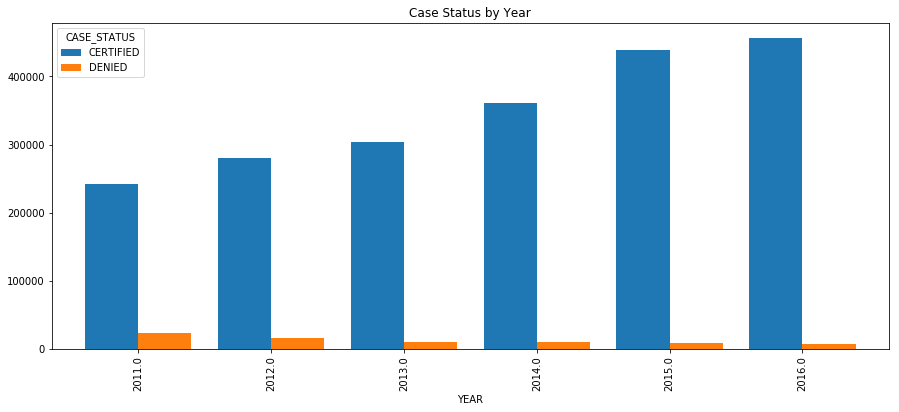

,YEAR,CASE_STATUS,SOC_NAME
0,2011.0,CERTIFIED,241665
1,2011.0,DENIED,23222
2,2012.0,CERTIFIED,279992
3,2012.0,DENIED,16746
4,2013.0,CERTIFIED,304049
5,2013.0,DENIED,9617
6,2014.0,CERTIFIED,360832
7,2014.0,DENIED,9465
8,2015.0,CERTIFIED,438189
9,2015.0,DENIED,8720


In [23]:
case_year = df1.groupby(['YEAR','CASE_STATUS'])['SOC_NAME'].count().reset_index()
case_year.pivot('YEAR','CASE_STATUS','SOC_NAME').plot.bar(width=0.8)
fig = plt.gcf()
fig.set_size_inches(15,6)
plt.title('Case Status by Year')
plt.show()
case_year

In [24]:
count_cer = case_year.loc[case_year['CASE_STATUS'] == 'CERTIFIED']
count_de = case_year.loc[case_year['CASE_STATUS'] == 'DENIED']

In [26]:
rate = count_cer['SOC_NAME'].values / (count_cer['SOC_NAME'].values + count_de['SOC_NAME'].values)
rate #연도에 따라 certificated 비율이 늘어나고 있다

array([0.91233243, 0.94356638, 0.96934   , 0.97443944, 0.9804882 ,
       0.98428854])

### EMPLOYEER

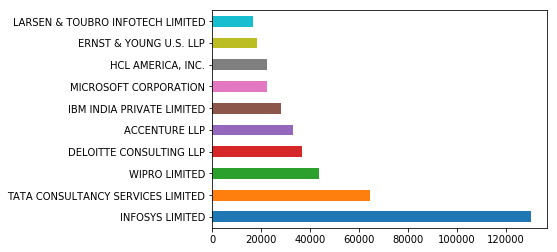

In [23]:
employer = df1['EMPLOYER_NAME'].value_counts().sort_values(ascending=False)[:10].plot.barh()

### 좋은 회사가 certified 비율이 높으려나?

In [38]:
cer_rate = df1[df1['CASE_STATUS'] == 'CERTIFIED']
cer_rate = cer_rate.groupby(['EMPLOYER_NAME','CASE_STATUS'])['YEAR'].count().reset_index()
de_rate = df1[df1['CASE_STATUS'] == 'DENIED']
de_rate = de_rate.groupby(['EMPLOYER_NAME','CASE_STATUS'])['YEAR'].count().reset_index()
cer = cer_rate.sort_values('YEAR', ascending = False)[:100]
de = de_rate.sort_values('YEAR',ascending =False)[:100]

In [39]:
cer_rate2 = df1[df1['CASE_STATUS'] == 'CERTIFIED']
cer_rate2 = cer_rate2.groupby(['EMPLOYER_NAME'])['YEAR'].count().reset_index()
de_rate2 = df1[df1['CASE_STATUS'] == 'DENIED']
de_rate2 = de_rate2.groupby(['EMPLOYER_NAME'])['YEAR'].count().reset_index()
cer2 = cer_rate2.sort_values('YEAR', ascending = False)
de2 = de_rate2.sort_values('YEAR',ascending =False)

In [52]:
de2

,EMPLOYER_NAME,YEAR
10623,DELOITTE CONSULTING LLP,440
18143,IBM INDIA PRIVATE LIMITED,343
13026,ERNST & YOUNG US LLP,278
18823,INFOSYS LIMITED,258
8593,COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION,199
16026,GOOGLE INC,162
43246,WIPRO LIMITED,158
14768,FUJITSU AMERICA INC,157
10621,DELOITTE & TOUCHE LLP,127
18142,IBM CORPORATION,125


In [58]:
cer_de2 = cer2.merge(de2,left_on = 'EMPLOYER_NAME',right_on = 'EMPLOYER_NAME',how='left')
cer_de2['Certified_rate'] = cer_de2['YEAR_x']/(cer_de2['YEAR_x']+cer_de2['YEAR_y'])

In [59]:
cer_de2.isnull().sum()

EMPLOYER_NAME          0
YEAR_x                 0
YEAR_y            138666
Certified_rate    138666
dtype: int64

In [41]:
cer_de2

,EMPLOYER_NAME,YEAR_x,YEAR_y,Certified_rate
0,INFOSYS LIMITED,103967,258.0,0.997525
1,TATA CONSULTANCY SERVICES LIMITED,51342,99.0,0.998075
2,WIPRO LIMITED,34618,158.0,0.995457
3,DELOITTE CONSULTING LLP,28915,440.0,0.985011
4,ACCENTURE LLP,26501,59.0,0.997779
5,IBM INDIA PRIVATE LIMITED,22251,343.0,0.984819
6,MICROSOFT CORPORATION,17834,34.0,0.998097
7,HCL AMERICA INC,17776,77.0,0.995687
8,ERNST & YOUNG US LLP,14370,278.0,0.981021
9,CAPGEMINI AMERICA INC,13381,85.0,0.993688


In [60]:
cer_de2.sort_values('Certified_rate',ascending=True)[['EMPLOYER_NAME','Certified_rate']][:10]
#마소가 높다, 모두 95%가 넘는다

,EMPLOYER_NAME,Certified_rate
153972,NORTHERN MARIANAS COLLEGE,0.066667
171698,INSTITUTO COMERCIAL DE PUERTO RICO,0.100000
166904,GLOBAL ALLIED SERVICES CORP,0.111111
162241,HOPKINS COUNTY COAL LLC,0.111111
142472,BAY PINES VA HEALTHCARE SYSTEM,0.125000
137719,ADM SECURITY SERVICES LLC,0.125000
120688,CJ FRESHWAY AMERICA CORPORATION,0.125000
170139,KSWB-TV FOX 5 A DIVISION OF TRIBUNE TELEVISION CO,0.125000
131950,ANARI INC,0.125000
95643,UNIVERSAL DENTAL LABORATORY LLC,0.142857


# Model

In [25]:
df_final = df1.drop('WORKSITE',axis=1)
df_final = df_final.drop('lon',axis=1)
df_final = df_final.drop('lat',axis=1)

In [26]:
df_final = df_final.iloc[:,1:9]

## SVM

In [145]:
from sklearn.model_selection import train_test_split

In [265]:
df_final = df_final.dropna()

In [266]:
X = df_final.iloc[:,1:8]
y = df_final.iloc[:,0]

In [267]:
y = y.replace('CERTIFIED','1')

In [268]:
y = y.replace('DENIED','0')

In [270]:
X_temp = X.iloc[:,3:6]

In [271]:
X_temp = X_temp.replace('Y','1')

In [272]:
X_temp = X_temp.replace('N','0')

In [273]:
print('Number of entries:', X_temp.shape[0])
print(X_temp.isnull().sum())

Number of entries: 1617233
FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
dtype: int64


In [274]:
X_train, X_test, y_train, y_test = train_test_split(X_temp,y,test_size =0.20, random_state = 0)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [275]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
def svc():
    from sklearn.metrics import confusion_matrix
    from sklearn.svm import SVC

    # 이곳에만 코드를 채우시면 됩니다.
    clf = SVC(C = 1e9, gamma= 1e-07)
    clf.fit(X_train, y_train) # 이곳은 건드릴 필요X
    y_scores = clf.decision_function(X_test) > -220
    confusion_matrix = confusion_matrix(y_test,y_scores)

    return confusion_matrix # 정답 리턴

svc()

## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0) #분류 문제에서는 0.5에서 랜덤으로 분류해서 고정해야되니까)
classifier.fit(X_train,y_train)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
##Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)

## Random Forest

In [89]:
df1.to_csv('yonsik.csv')

#### 명목변수 변환
1.   Employer name – , 랑 . 없애서 통합 – certified rate를 정규화
2.   SOC_NAME – 현재 upper까지 했고, 직업 이름 뒤에 S 붙는 애들 없애기 – certified rate 정규화
3.   JOB_TITLE은 SOC_NAME이랑 공선성 있다고 의심, 일단 넣고 나중에 빼보기
4.   FULL_TIME_POSITION -> 1,0
5.   Prevailing_wage – 정규화
6.   YEAR – dummy 변수로
7.   Worksite, lon, lat -> State
l   train에는 있고, test에는 없는 명목형 변수 어떻게 처리 ?

In [36]:
df1.head()

,CASE_STATUS,EMPLOYER_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,SOC_NAME,TEST,WORKSITE,YEAR,State
0,CERTIFIED,INTERNATIONAL SYSTEMS TECHNOLOGIES INC,1.0,-0.015817,COMPUTER PROGRAMMERS,0,"SUNNYVALE, CALIFORNIA",2014.0,CALIFORNIA
1,CERTIFIED,GOOGLE INC,1.0,-0.012609,NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS,0,"SAN FRANCISCO, CALIFORNIA",2015.0,CALIFORNIA
2,CERTIFIED,WIPRO LIMITED,1.0,-0.013571,"COMPUTER OCCUPATIONS, ALL OTHER",0,"EL SEGUNDO, CALIFORNIA",2014.0,CALIFORNIA
3,CERTIFIED,CPO SERVICES INC,1.0,-0.015817,ORTHOTISTS AND PROSTHETISTS,0,"PEORIA, ILLINOIS",2011.0,ILLINOIS
5,DENIED,UNIVERSITY OF CALIFORNIA SAN DIEGO,1.0,-0.019374,"MEDICAL SCIENTISTS, EXCEPT EPIDEMIOLOGISTS",0,"LA JOLLA, CALIFORNIA",2015.0,CALIFORNIA


In [30]:
df1['EMPLOYER_NAME'] = df1['EMPLOYER_NAME'].str.replace('.','')

In [31]:
df1['EMPLOYER_NAME'] = df1['EMPLOYER_NAME'].str.replace(',','')

In [33]:
np.mean(df1['PREVAILING_WAGE'])

148152.2998651202

In [34]:
df1['PREVAILING_WAGE'] = (df1['PREVAILING_WAGE'] - np.mean(df1['PREVAILING_WAGE'])) / np.std(df1['PREVAILING_WAGE'])

In [35]:
np.mean(df1['PREVAILING_WAGE'])

-2.9988344101337636e-16

In [61]:
cer_de2.head()

,EMPLOYER_NAME,YEAR_x,YEAR_y,Certified_rate
0,INFOSYS LIMITED,103967,258.0,0.997525
1,TATA CONSULTANCY SERVICES LIMITED,51342,99.0,0.998075
2,WIPRO LIMITED,34618,158.0,0.995457
3,DELOITTE CONSULTING LLP,28915,440.0,0.985011
4,ACCENTURE LLP,26501,59.0,0.997779


In [62]:
cer_dee = cer_de2['EMPLOYER_NAME']

In [63]:
cer_dee = pd.concat([cer_dee,cer_de2['Certified_rate']],axis=1)
cer_dee.head()

,EMPLOYER_NAME,Certified_rate
0,INFOSYS LIMITED,0.997525
1,TATA CONSULTANCY SERVICES LIMITED,0.998075
2,WIPRO LIMITED,0.995457
3,DELOITTE CONSULTING LLP,0.985011
4,ACCENTURE LLP,0.997779


In [64]:
df2 = pd.merge(df1,cer_dee,how='left')

In [65]:
df2.isnull().sum()

CASE_STATUS           541570
EMPLOYER_NAME             28
FULL_TIME_POSITION        11
PREVAILING_WAGE           63
SOC_NAME               15903
TEST                       0
WORKSITE                   0
YEAR                      10
State                      0
Certified_rate        704030
dtype: int64

In [67]:
df2.head()

,CASE_STATUS,EMPLOYER_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,SOC_NAME,TEST,WORKSITE,YEAR,State,Certified_rate
0,CERTIFIED,INTERNATIONAL SYSTEMS TECHNOLOGIES INC,1.0,-0.015817,COMPUTER PROGRAMMERS,0,"SUNNYVALE, CALIFORNIA",2014.0,CALIFORNIA,0.997976
1,CERTIFIED,GOOGLE INC,1.0,-0.012609,NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS,0,"SAN FRANCISCO, CALIFORNIA",2015.0,CALIFORNIA,0.984573
2,CERTIFIED,WIPRO LIMITED,1.0,-0.013571,"COMPUTER OCCUPATIONS, ALL OTHER",0,"EL SEGUNDO, CALIFORNIA",2014.0,CALIFORNIA,0.995457
3,CERTIFIED,CPO SERVICES INC,1.0,-0.015817,ORTHOTISTS AND PROSTHETISTS,0,"PEORIA, ILLINOIS",2011.0,ILLINOIS,NaN
4,DENIED,UNIVERSITY OF CALIFORNIA SAN DIEGO,1.0,-0.019374,"MEDICAL SCIENTISTS, EXCEPT EPIDEMIOLOGISTS",0,"LA JOLLA, CALIFORNIA",2015.0,CALIFORNIA,0.972019


In [69]:
df2.rename(columns = {df2.columns[9] : 'CR_EMPLOYER'}, inplace = True )

In [70]:
df2.head()

,CASE_STATUS,EMPLOYER_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,SOC_NAME,TEST,WORKSITE,YEAR,State,CR_EMPLOYER
0,CERTIFIED,INTERNATIONAL SYSTEMS TECHNOLOGIES INC,1.0,-0.015817,COMPUTER PROGRAMMERS,0,"SUNNYVALE, CALIFORNIA",2014.0,CALIFORNIA,0.997976
1,CERTIFIED,GOOGLE INC,1.0,-0.012609,NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS,0,"SAN FRANCISCO, CALIFORNIA",2015.0,CALIFORNIA,0.984573
2,CERTIFIED,WIPRO LIMITED,1.0,-0.013571,"COMPUTER OCCUPATIONS, ALL OTHER",0,"EL SEGUNDO, CALIFORNIA",2014.0,CALIFORNIA,0.995457
3,CERTIFIED,CPO SERVICES INC,1.0,-0.015817,ORTHOTISTS AND PROSTHETISTS,0,"PEORIA, ILLINOIS",2011.0,ILLINOIS,NaN
4,DENIED,UNIVERSITY OF CALIFORNIA SAN DIEGO,1.0,-0.019374,"MEDICAL SCIENTISTS, EXCEPT EPIDEMIOLOGISTS",0,"LA JOLLA, CALIFORNIA",2015.0,CALIFORNIA,0.972019


In [71]:
df2['CR_EMPLOYER'] = (df2['CR_EMPLOYER'] - np.mean(df2['CR_EMPLOYER'])) / np.std(df2['CR_EMPLOYER'])

In [73]:
YEAR_OHE = pd.get_dummies(df2.YEAR)

In [74]:
df2.head()

,CASE_STATUS,EMPLOYER_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,SOC_NAME,TEST,WORKSITE,YEAR,State,CR_EMPLOYER
0,CERTIFIED,INTERNATIONAL SYSTEMS TECHNOLOGIES INC,1.0,-0.015817,COMPUTER PROGRAMMERS,0,"SUNNYVALE, CALIFORNIA",2014.0,CALIFORNIA,0.404204
1,CERTIFIED,GOOGLE INC,1.0,-0.012609,NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS,0,"SAN FRANCISCO, CALIFORNIA",2015.0,CALIFORNIA,0.258826
2,CERTIFIED,WIPRO LIMITED,1.0,-0.013571,"COMPUTER OCCUPATIONS, ALL OTHER",0,"EL SEGUNDO, CALIFORNIA",2014.0,CALIFORNIA,0.376880
3,CERTIFIED,CPO SERVICES INC,1.0,-0.015817,ORTHOTISTS AND PROSTHETISTS,0,"PEORIA, ILLINOIS",2011.0,ILLINOIS,NaN
4,DENIED,UNIVERSITY OF CALIFORNIA SAN DIEGO,1.0,-0.019374,"MEDICAL SCIENTISTS, EXCEPT EPIDEMIOLOGISTS",0,"LA JOLLA, CALIFORNIA",2015.0,CALIFORNIA,0.122662


In [75]:
df3 = pd.concat([df2,YEAR_OHE],axis=1)

In [77]:
del df3['EMPLOYER_NAME']
del df3['SOC_NAME']
del df3['WORKSITE']
del df3['YEAR']
del df3['State']

In [78]:
df3.head()

,CASE_STATUS,FULL_TIME_POSITION,PREVAILING_WAGE,TEST,CR_EMPLOYER,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
0,CERTIFIED,1.0,-0.015817,0,0.404204,0,0,0,1,0,0
1,CERTIFIED,1.0,-0.012609,0,0.258826,0,0,0,0,1,0
2,CERTIFIED,1.0,-0.013571,0,0.376880,0,0,0,1,0,0
3,CERTIFIED,1.0,-0.015817,0,NaN,1,0,0,0,0,0
4,DENIED,1.0,-0.019374,0,0.122662,0,0,0,0,1,0


In [79]:
df3_test = df3[df3['TEST'] == 1]
df3_train = df3[df3['TEST'] == 0]

In [80]:
df3_test.head()
df3_train.head()

,CASE_STATUS,FULL_TIME_POSITION,PREVAILING_WAGE,TEST,CR_EMPLOYER,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
1626895,NaN,1.0,-0.019036,1,0.342724,0,1,0,0,0,0
1626896,NaN,0.0,-0.014487,1,0.405286,0,0,0,0,0,1
1626897,NaN,1.0,-0.013023,1,NaN,0,0,0,0,1,0
1626898,NaN,1.0,-0.014004,1,0.325360,0,1,0,0,0,0
1626899,NaN,1.0,-0.012043,1,-0.102952,0,0,0,0,0,1


In [82]:
df3_test['CR_EMPLOYER'] = df3_test['CR_EMPLOYER'].fillna(0)
df3_train['CR_EMPLOYER'] = df3_train['CR_EMPLOYER'].fillna(0)

C:\Users\test\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [88]:
df3_train.head()
del df3_test['TEST']
del df3_train['TEST']

In [89]:
df3_train.head()

,CASE_STATUS,FULL_TIME_POSITION,PREVAILING_WAGE,CR_EMPLOYER,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
0,CERTIFIED,1.0,-0.015817,0.404204,0,0,0,1,0,0
1,CERTIFIED,1.0,-0.012609,0.258826,0,0,0,0,1,0
2,CERTIFIED,1.0,-0.013571,0.376880,0,0,0,1,0,0
3,CERTIFIED,1.0,-0.015817,0.000000,1,0,0,0,0,0
4,DENIED,1.0,-0.019374,0.122662,0,0,0,0,1,0


In [91]:
df3_train['CASE_STATUS'] = df3_train['CASE_STATUS'].replace('CERTIFIED',0)
df3_train['CASE_STATUS'] = df3_train['CASE_STATUS'].replace('DENIED',1)

C:\Users\test\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\test\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
df3_

In [107]:
df3_train_sub = df3_train.iloc[1:50000,:]

# SVM

In [101]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]} 

{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [108]:
y = df3_train_sub['CASE_STATUS']

In [111]:
X = df3_train_sub
X.head()

,FULL_TIME_POSITION,PREVAILING_WAGE,CR_EMPLOYER,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
1,1.0,-0.012609,0.258826,0,0,0,0,1,0
2,1.0,-0.013571,0.376880,0,0,0,1,0,0
3,1.0,-0.015817,0.000000,1,0,0,0,0,0
4,1.0,-0.019374,0.122662,0,0,0,0,1,0
5,1.0,-0.012081,0.258826,1,0,0,0,0,0


In [115]:
X['PREVAILING_WAGE'] = X['PREVAILING_WAGE'].fillna(np.mean(X['PREVAILING_WAGE']))

C:\Users\test\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [117]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# overfitting 방지를 위해 training, test set으로 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
grid_search.fit(X_train, y_train)

print("최적 매개변수 : ",grid_search.best_params_) 
print("최상 교차검증 점수 : ",grid_search.best_score_)
print("최고 성능 모델 : ",grid_search.best_estimator_)

KeyboardInterrupt: 

In [ ]:
svm = SVC(gamma=?, C=?)

In [ ]:
y_pred = classifier.predict(X_test)